## Regime Summary — Research & Validation

### Core hypothesis

#### H₁ — Buy-Low / Sell-High
Lower regime buckets (e.g. 1–3) have higher future returns than higher buckets.

#### H₂ — Buy-High / Sell-Higher
Higher regime buckets (e.g. 8–10) continue to outperform.

### 1. Imports + config

In [ ]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.oauth2 import service_account

### 2. Load env + credentials

In [ ]:
PROJECT_ID = os.getenv("GCP_PROJECT_ID")
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

print("GCP_PROJECT_ID =", PROJECT_ID)
print("GOOGLE_APPLICATION_CREDENTIALS =", KEY_PATH)

if not PROJECT_ID:
    raise RuntimeError("Missing env var: GCP_PROJECT_ID")
if not KEY_PATH:
    raise RuntimeError("Missing env var: GOOGLE_APPLICATION_CREDENTIALS")
if not Path(KEY_PATH).exists():
    raise FileNotFoundError(f"Credential file not found: {KEY_PATH}")

# Optional sanity check (project_id in key)
with open(KEY_PATH, "r") as f:
    key_json = json.load(f)
print("project_id in key =", key_json.get("project_id"))


GCP_PROJECT_ID = robotic-weft-480502-c2
GOOGLE_APPLICATION_CREDENTIALS = /home/shpang/.keys/robotic-weft-480502-c2.json
project_id in key = robotic-weft-480502-c2


### 3. BigQuery client

In [7]:
creds = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(project=PROJECT_ID, credentials=creds)

print("BigQuery client project:", client.project)


BigQuery client project: robotic-weft-480502-c2


### 4. Load from Core Fact price & regime

In [8]:
QUERY = f"""
SELECT
  p.trade_date,
  p.ticker,
  r.regime_bucket_10,
  p.fwd_return_1d,
  p.fwd_return_5d,
  p.fwd_return_10d,
  p.fwd_return_20d
FROM `{PROJECT_ID}.mag7_intel_core.fact_prices` p
JOIN `{PROJECT_ID}.mag7_intel_core.fact_regimes` r
  USING (trade_date, ticker)
WHERE r.regime_bucket_10 IS NOT NULL
"""

df = client.query(QUERY).to_dataframe()

df["trade_date"] = pd.to_datetime(df["trade_date"])
df["regime_bucket_10"] = df["regime_bucket_10"].astype("Int64")

df.head(), df.shape


/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(  trade_date ticker  regime_bucket_10  fwd_return_1d  fwd_return_5d  \
 0 2025-03-18   MSFT                 1       0.011212       0.030351   
 1 2022-04-26   META                 1      -0.033158       0.171760   
 2 2022-04-26   MSFT                 1       0.048109       0.042780   
 3 2022-04-26  GOOGL                 1      -0.036709      -0.011091   
 4 2022-04-26   AMZN                 1      -0.008781      -0.108597   
 
    fwd_return_10d  fwd_return_20d  
 0       -0.003468        0.005763  
 1        0.092291        0.001824  
 2       -0.002665       -0.036989  
 3       -0.035862       -0.106869  
 4       -0.219039       -0.253180  ,
 (10444, 7))

### 5. Stage 1A: counts / coverage (first gate)

In [9]:
counts = df.groupby("regime_bucket_10").size().sort_index()
counts

regime_bucket_10
1      732
2      502
3      516
4      511
5      588
6      677
7      785
8     1163
9     1718
10    3252
dtype: int64

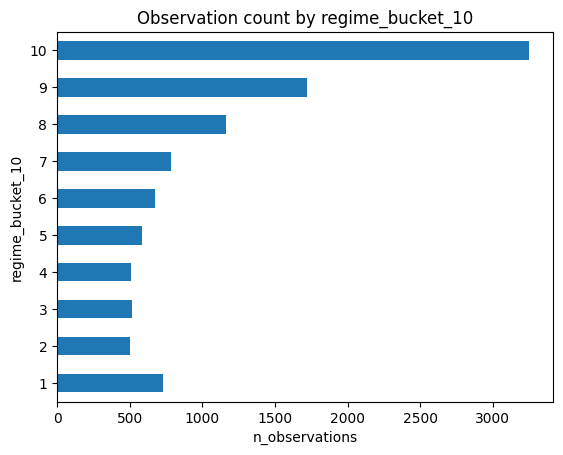

In [11]:
plt.figure()
counts.sort_index().plot(kind="barh")
plt.title("Observation count by regime_bucket_10")
plt.xlabel("n_observations")
plt.ylabel("regime_bucket_10")
plt.show()

In [12]:
df.groupby("regime_bucket_10")["fwd_return_20d"].mean()

regime_bucket_10
1     0.031838
2     0.034121
3     0.036395
4     0.035672
5     0.014502
6     0.027725
7     0.032596
8     0.025013
9     0.030182
10    0.033280
Name: fwd_return_20d, dtype: float64

In [13]:
price_check = (
    df
    .merge(
        client.query(f"""
            SELECT trade_date, ticker, close
            FROM `{PROJECT_ID}.mag7_intel_core.fact_prices`
        """).to_dataframe(),
        on=["trade_date", "ticker"],
        how="left"
    )
    .groupby("regime_bucket_10")["close"]
    .mean()
    .sort_index()
)

price_check


/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


ValueError: You are trying to merge on datetime64[ns] and dbdate columns for key 'trade_date'. If you wish to proceed you should use pd.concat